In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
import pickle
import gzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


2025-05-06 12:03:40.591920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
soap_path = '/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/padded_soap_descriptors.pkl.gz'
# Step 1: Read the compressed pickle
with gzip.open(soap_path, 'rb') as f:
    soap_df = pickle.load(f)



In [6]:
print(padded_df.shape)
padded_df.head(10)

reduced_padded_df = padded_df[padded_df['gap opt'] >= 0.2]
print("filted soap data shape: ", reduced_padded_df.shape)

X = np.array(reduced_padded_df['padded_soap'].tolist())
X = X[..., np.newaxis]  # Add a channel dimension -> (N, 64, 800, 1)
y = np.array(reduced_padded_df['gap opt'].tolist())

print("X shape: ", X.shape)
print("y shape: ", y.shape)

(5358, 4)
filted soap data shape:  (3253, 4)
X shape:  (3253, 64, 800, 1)
y shape:  (3253,)


In [3]:
import matplotlib.pyplot as plt

# for i, soap in enumerate(padded_df['padded_soap']):
#     plt.imshow(soap)
#     plt.title(f"{padded_df['formula'].iloc[i]}")
#     # plt.colorbar()
#     plt.show()
#     if i == 5:
#         break


# CNN

In [4]:
# plt.hist(padded_df['gap opt'], bins=20)
# plt.hist(reduced_padded_df['gap opt'], bins=20)


In [60]:
# Assuming your input data is (num_samples, 64, 800)
X = np.array(reduced_padded_df['padded_soap'].tolist())
X = X[..., np.newaxis]  # Add a channel dimension -> (N, 64, 800, 1)
X_train, X_test, y_train, y_test = train_test_split(X, reduced_padded_df['gap opt'], test_size=0.2, random_state=42)

y = np.array(reduced_padded_df['gap opt'].tolist())  # regression target
print(X.shape, y.shape)
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(64, 800, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1)  # bandgap output
])

model.compile(optimizer='adam', loss='mae', metrics=['mae'])

model.summary()

(3253, 64, 800, 1) (3253,)


/Users/cadenmyers/miniconda3/envs/tfenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 60, 796, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 796, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 398, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 26, 394, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 26, 394, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 197, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 163904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    20,979,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,032,449 (80.23 MB)

 Trainable params: 21,032,257 (80.23 MB)

 Non-trainable params: 192 (768.00 B)

In [61]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - loss: 16.1492 - mae: 16.1492 - val_loss: 3.3521 - val_mae: 3.3521
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - loss: 2.2087 - mae: 2.2087 - val_loss: 2.8778 - val_mae: 2.8778
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 1.7104 - mae: 1.7104 - val_loss: 2.7730 - val_mae: 2.7730
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - loss: 1.7611 - mae: 1.7611 - val_loss: 3.0242 - val_mae: 3.0242
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - loss: 1.5116 - mae: 1.5116 - val_loss: 2.9139 - val_mae: 2.9139
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - loss: 1.4223 - mae: 1.4223 - val_loss: 2.3627 - val_mae: 2.3627
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - loss: 1.3497 - mae: 1.3497 - val_loss: 2.1153 - val_mae: 2.1153
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 1.4155 - mae: 1.4155 - val_loss: 1.8171 - val_mae: 1.8171
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 1.4

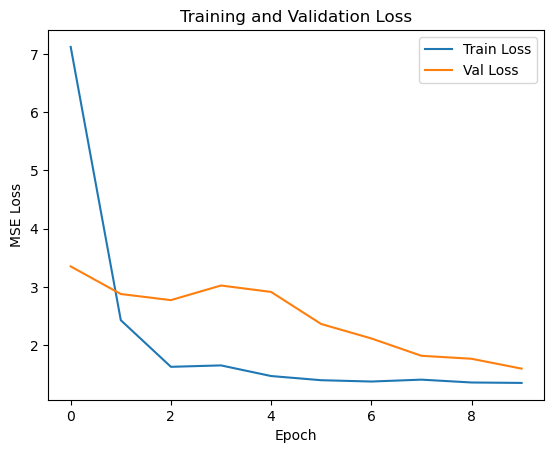

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 1.5763 - mae: 1.5763
Test MAE: 1.5367 eV


In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f} eV")


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step


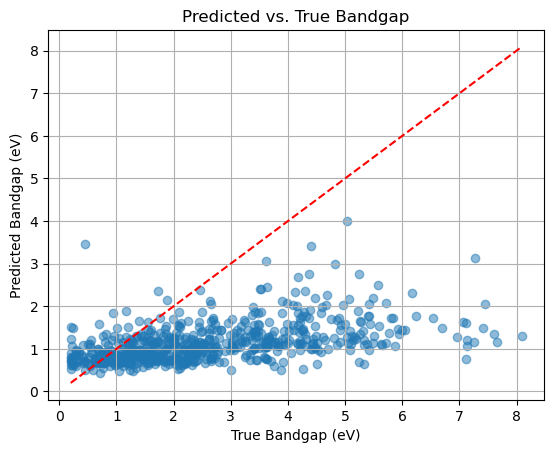

In [63]:
y_pred = model.predict(X_test).flatten()

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Bandgap (eV)")
plt.ylabel("Predicted Bandgap (eV)")
plt.title("Predicted vs. True Bandgap")
plt.grid(True)
plt.show()

# Dimensionality reduction with PCA

In [7]:
from sklearn.decomposition import PCA

X_flat = X.reshape(X.shape[0], -1)  # shape: (N, 64*800)
print("X_flat shape: ", X_flat.shape)

pca = PCA(n_components=300)
X_pca = pca.fit_transform(X_flat)  # Shape: (N, n_components)


In [95]:
print("Explained variance ratio sum:", np.sum(pca.explained_variance_ratio_))  # Total variance retained


# for i in range(20):
#     plt.subplot(4, 5, i + 1)
#     plt.imshow(X_pca[i].reshape(10, 10), cmap='viridis')
#     plt.title(f"PC {i+1}")
#     plt.axis('off')
# plt.plot(X_pca[0])

Explained variance ratio sum: 0.9953385696589431


# Ridge regression and random forrest

In [11]:

X_flat = X.reshape(X.shape[0], -1)  # shape: (N, 64*800)

X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print("Ridge MAE:", mean_absolute_error(y_test, y_pred))

lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print("Lasso MAE:", mean_absolute_error(y_test, y_pred_lasso))

# rf = RandomForestRegressor()
# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)
# print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))

Ridge MAE: 1.7924492543027815
Lasso MAE: 1.235158528755203


# XGboost

In [9]:

X_flat = X.reshape(X.shape[0], -1)  # shape: (N, 64*800)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

xgb_raw = XGBRegressor()
xgb_raw.fit(X_train_raw, y_train)
y_pred_raw = xgb_raw.predict(X_test_raw)
print("XGBoost MAE on raw data:", mean_absolute_error(y_test, y_pred_raw))

X_train_pca, X_test_pca, _, _ = train_test_split(X_pca, y, test_size=0.2, random_state=42)

xgb_pca = XGBRegressor()
xgb_pca.fit(X_train_pca, y_train)
y_pred_pca = xgb_pca.predict(X_test_pca)
print("XGBoost MAE on PCA-reduced data:", mean_absolute_error(y_test, y_pred_pca))

XGBoost MAE on raw data: 0.9658480139832708
XGBoost MAE on PCA-reduced data: 0.9936982107306039


In [ ]:
# Save the model
# import joblib

# # # Save model to a file
# joblib.dump(rf, 'filtered_random_forest_model.pkl')

['filtered_random_forest_model.pkl']

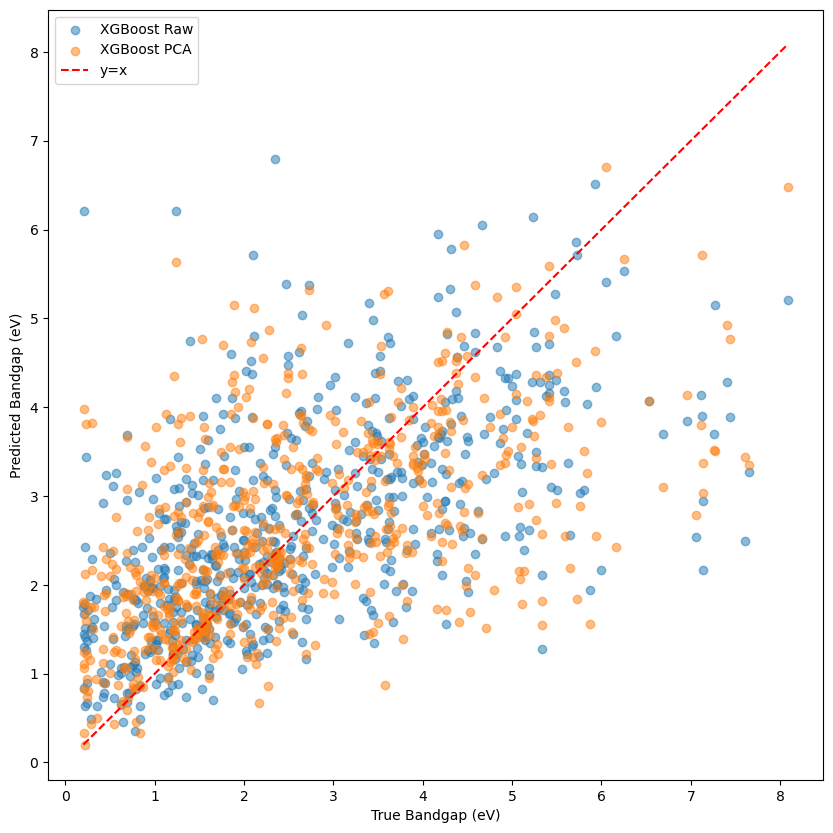

In [13]:
def parity_line(x, slope, intercept):
    return slope * x + intercept

xs =np.arange(y_test.min(), y_test.max(), 0.01)
parity = parity_line(xs, 1, 0)

plt.figure(figsize=(10, 10))
# plt.scatter(y_test, y_pred, alpha=0.5, label='Ridge')
# plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
# plt.scatter(y_test, y_pred_lasso, alpha=0.5, label='Lasso')
plt.scatter(y_test, y_pred_raw, alpha=0.5, label='XGBoost Raw')
plt.scatter(y_test, y_pred_pca, alpha=0.5, label='XGBoost PCA')
plt.plot(xs, parity, 'r--', label='y=x')
# plt.ylim(y_test.min(), y_test.max())
plt.xlabel("True Bandgap (eV)")
plt.ylabel("Predicted Bandgap (eV)")
plt.legend()


In [17]:
data_path = "/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/soap_and_atomic_features.pkl.gz"
# Step 1: Read the compressed pickle
with gzip.open(data_path, 'rb') as f:
    data_df = pickle.load(f)


In [ ]:
from sklearn.preprocessing import StandardScaler

X_atomic = data_df.drop(columns=['mpid', 'gap opt', 'padded_soap', 'soap_flat'])
X_atomic.head()
scaler = StandardScaler()
X_atomic_vectors = scaler.fit_transform(X_atomic.drop(columns=['formula']).to_numpy())
X_combined = np.hstack([np.vstack(data_df['soap_flat']), X_atomic_vectors])
print('soap vector shape:', data_df['soap_flat'].iloc[0].shape)
print('X_atomic shape:', X_atomic.shape)
print('X_combined shape:', X_combined.shape)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, data_df['gap opt'], test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

soap vector shape: (51200,)
X_atomic shape: (5358, 21)
X_combined shape: (5358, 51220)
X_train shape: (4286, 51220)
X_test shape: (1072, 51220)
y_train shape: (4286,)
y_test shape: (1072,)


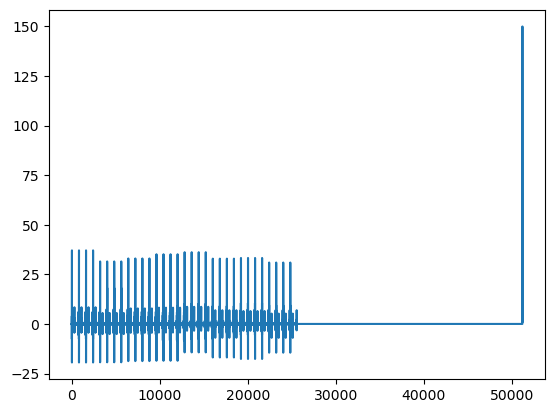

In [19]:
plt.plot(X_combined[0])